# Cómputo Cuántico en la nube

## 1. Configuración

Se debe contar con las siguientes bibliotecas: 
```shell 
pip install matplotlib pylatexenc 
pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-aer 
``` 

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import qasm2
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
from qiskit_ibm_provider import IBMProvider, least_busy
import numpy  as np
import math

In [3]:
# Argumentos para los diagramas
draw_kwargs = {
        "output": "mpl",        # matplotlib
        "cregbundle": False,    # separa los cables
        "initial_state": True,  # muestra |0>
        "idle_wires": False,    # no mostar cables sin utilizar
    "style": {
        "subfontsize": 9,       # tamaño
        "dpi": 600
    }
}

Crear una cuenta en: [IBM Quantum Platform](https://quantum.ibm.com/). Iniciar sesión en ir a Dashboard. 

![Screenshot from 2024-09-23 10-12-03.png](<attachment:Screenshot from 2024-09-23 10-12-03.png>)
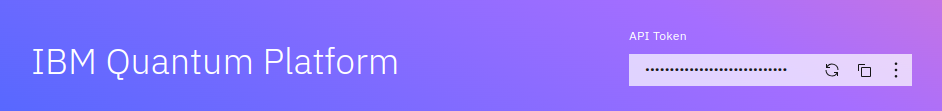

Copiar el API Token

Si es la primera vez que se ejecuta las siguientes líneas, el token se guarda en el disco duro en la dirección **$HOME/.qiskit/qiskit-ibm.json**. 

Solo debe ejecutarse una vez **QiskitRuntimeService.save_account()** para que se guarde el token. 

In [13]:
API_token = ""
QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_token, overwrite=True)

Verificar que se tenga acceso a los servidores

In [5]:
provider = IBMProvider()

## 2. Compuertas y Circuitos Cuánticos

Para visualizar la acción de las compuertas cuánticas es conveniente utilizar un simulador de la 
esfera de Bloch [Bloch Sphere Simulator](https://bloch.kherb.io/).
Los circuitos cuánticos puede ser construidos interactivamente con la herramienta de IBM
[IBM Quantum Composer](https://quantum.ibm.com/composer).

### 2.1 Circuitos de 1 qubit

In [ ]:
# Se inicia definiendo a los registros. Un registro cuántico como 
# q y un registro clásico como meas.
qreg_q = QuantumRegister(1, "q")
creg_c = ClassicalRegister(1, "meas")

# Creación de un circuito
qc = QuantumCircuit(qreg_q, creg_c)

# Compuerta X
qc.x(qreg_q[0])
qc.draw(**draw_kwargs)

In [ ]:
qc.measure(qreg_q[0], creg_c[0])
qc.draw(**draw_kwargs)

### 2.2 Simulación

In [ ]:
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
print(counts)

In [ ]:
print(qasm2.dumps(qc))

In [ ]:
plot_histogram(counts)

### 2.3 Más de 1 qubit
Entrelazamiento cuántico

In [ ]:
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
bell.draw(**draw_kwargs)

In [ ]:
simulator = AerSimulator()
result = simulator.run(bell, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [ ]:
qc = QuantumCircuit(3)

qc.h(0)  
qc.cx(0, 1) 
qc.x(2)
qc.cz(1, 2) 
qc.draw(**draw_kwargs) 

In [ ]:
qc.cz(1, 2)
qc.x(2)  
qc.cx(0, 1)  
qc.h(0)
qc.draw(**draw_kwargs)  

In [ ]:
qc.measure_all()
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

## 3. Computación cuántica en la nube

### 3.1 Servidores

In [ ]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

### 3.2 Hardware cuántico

In [18]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))

In [ ]:
print(device)

[Computing resources](https://quantum.ibm.com/services/resources)

In [ ]:
base, b = quantum_state = (-math.sqrt(3)/2, complex(0, 1/2))
norm = abs(base)**2 + abs(b)**2
print(norm)

In [ ]:
cqc = QuantumCircuit(1)
cqc.initialize(quantum_state, 0)
cqc.measure_all()
cqc.draw(**draw_kwargs)

In [ ]:
simulator = AerSimulator()
result = simulator.run(cqc, shots = 500).result() 
counts = result.get_counts(cqc)
plot_histogram(counts)
#plot_histogram([counts, counts1], legend=["a", "b"])

**Transpilation** es el proceso de rescribir una entrade de un circuito para que coincida con la topología específica de un dispositivo cuántico y/o optimizar la ejecución del circuito en los sistemas cuánticos con ruido. 

Esta operación sigue 6 pasos que pueden ser iterativos: 

- Optimización virtual del circuito 

- Descomposición a compuertas de 3 qubits 

- Posicionamiento de qubits físicos 

- Enrutamiento 

- Traducción a compuertas base 

- Optimización física del circuito 

In [ ]:
quantum_hw = provider.get_backend("ibm_sherbrooke")
qc_transpiled = transpile(cqc, quantum_hw)
qc_transpiled.draw(style = "iqd")


## 4. Algoritmo de Shor

In [16]:
import matplotlib.pyplot as plt

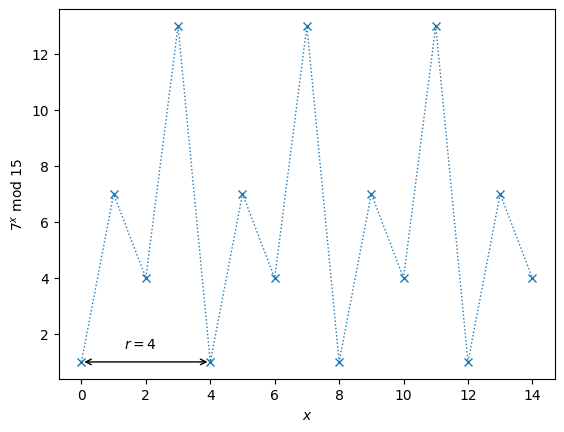

In [40]:
N = 15
base = 7

# valores
xvals = np.arange(N)
yvals = [np.mod(base**x, N) for x in xvals]

fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${base}^x$ mod ${N}$')
try: # encontrar el periodo cuando es 1
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('No ha periodo, a no tiene factores con N')

In [41]:
def fx_7mod15(a, power):
    U = QuantumCircuit(4)
    for i in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "7 ^ %i mod 15"%(power)
    c_U = U.control()
    return c_U

In [42]:
def c_amod15(base, power):
    if base not in [2,4,7,8,11,13]:
        raise ValueError("'a' tiene que ser 2,4,7,8,11 o 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if base in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if base in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if base in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if base in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{base}^{power} mod 15"
    c_U = U.control()
    return c_U

In [43]:
def QFTi(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for k in range(j):
            if k != j:
                qc.cu(-np.pi/float(2**(j-k)), 0, 0, 0, k, j)
        qc.h(j)
    qc.name = "QFTi"
    return qc

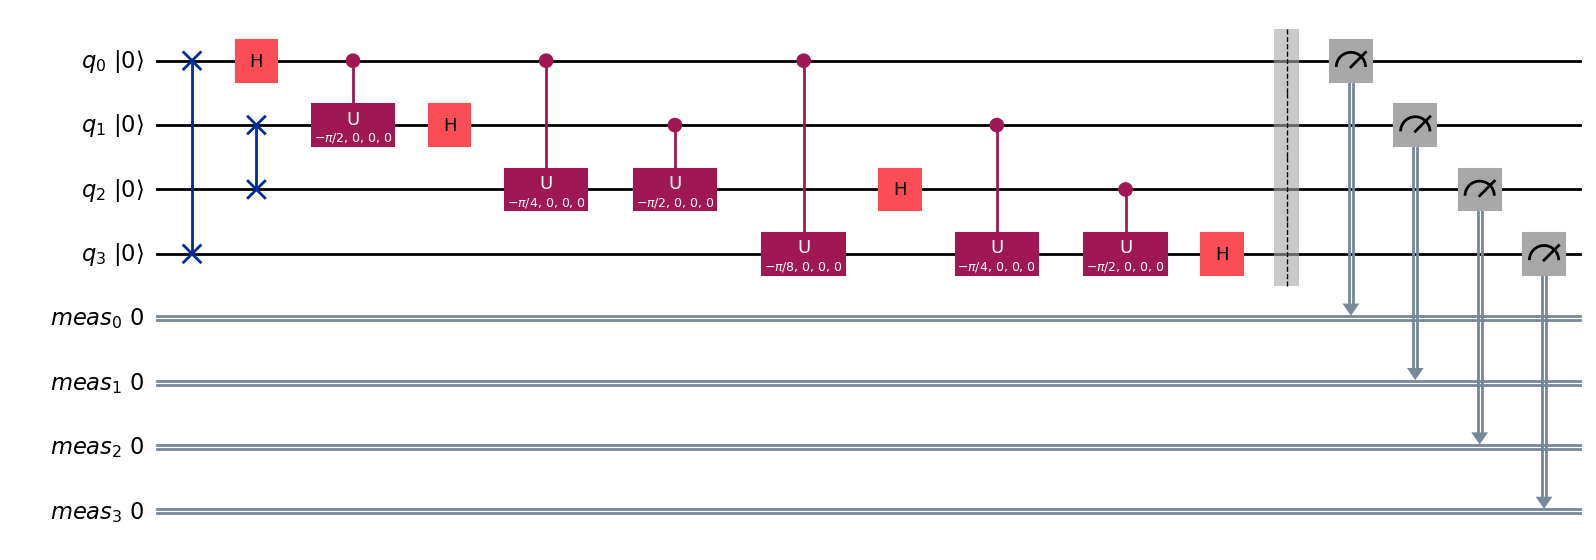

In [44]:
qc = QFTi(4)
qc.measure_all()
qc.draw(**draw_kwargs)

In [46]:
n_qubits = 4 #num qubits
base = 7
qc = QuantumCircuit(n_qubits+4, n_qubits)

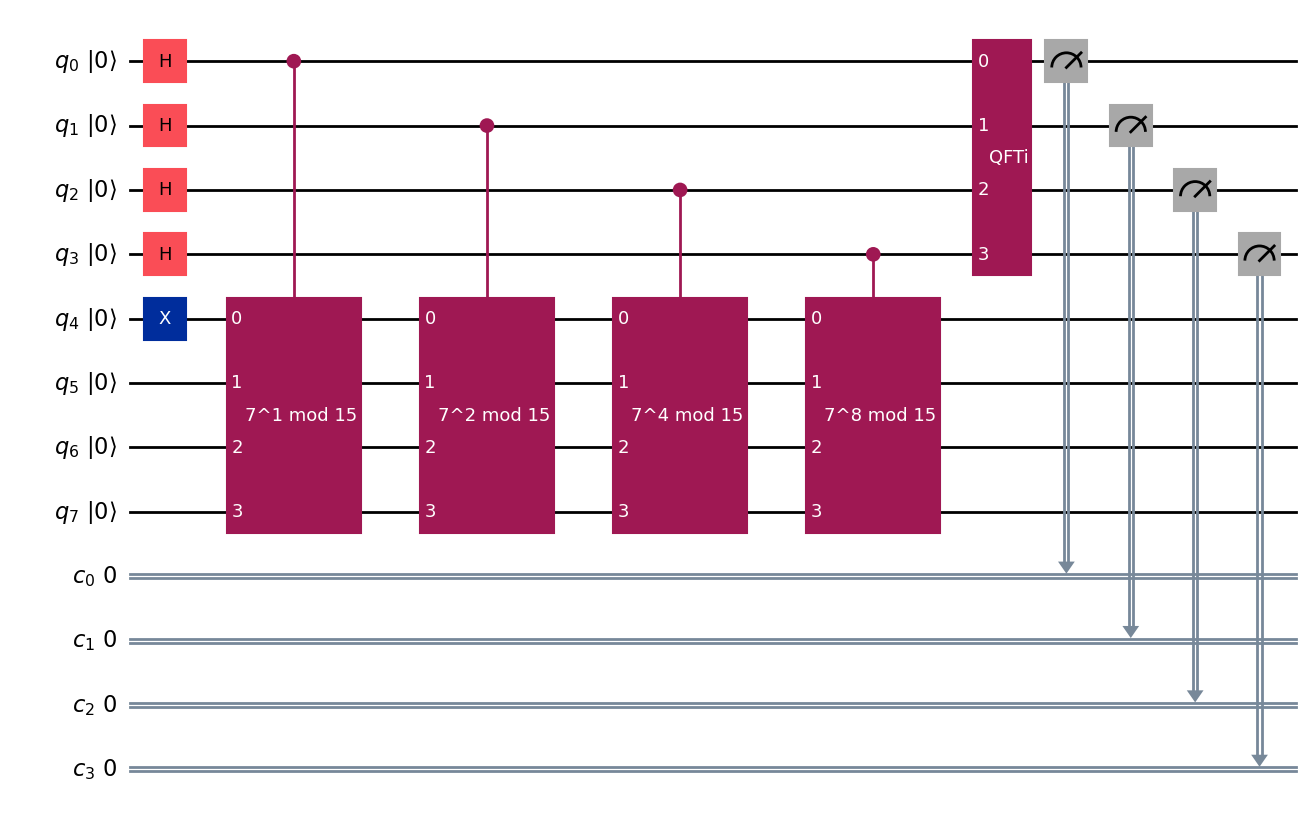

In [47]:
for q in range(n_qubits):
    qc.h(q)
qc.x(n_qubits)

for q in range(n_qubits):
    qc.append(c_amod15(base, 2**q),
             [q] + [i+n_qubits for i in range(4)])
qc.append(QFTi(n_qubits), range(n_qubits))
# qc.measure_all()
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(**draw_kwargs)

In [48]:
qc_dec = qc.decompose()
# qc_dec.draw(**draw_kwargs)

Resultados: {'0000': 263, '1100': 231, '1000': 284, '0100': 246}


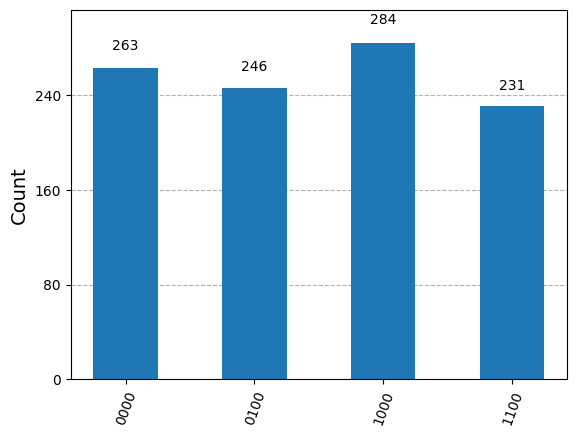

In [49]:
simulator = AerSimulator()
result = simulator.run(qc_dec, shots=1024).result()
counts = result.get_counts(0)
print("Resultados:", counts)
plot_histogram(counts)

In [50]:
from fractions import Fraction

In [51]:
frac = Fraction(4/16)
print(frac)
period = frac.denominator

1/4


In [52]:
def gcd(a, b):
    while b != 0:
        tmp = a % b
        a = b
        b = tmp
    return a

In [53]:
print("base: ", base, "N: ", N, "period: ", period)
print("factor: ",gcd(base**(period//2) +1, N))
print("factor: ",gcd(base**(period//2) -1, N))

base:  7 N:  15 period:  4
factor:  5
factor:  3


### 4.1 Shor en hardware cuántico

In [ ]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

In [ ]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))
print(device)

In [54]:
quantum_hw = provider.get_backend("ibm_brisbane")
qc_transpiled = transpile(qc_dec, quantum_hw)

In [ ]:
qc_transpiled.draw(style = "iqd")

In [55]:
job = quantum_hw.run(qc_transpiled, shots=1024)

In [56]:
job.job_id()

'cvynbzzz9es0008e7qy0'

In [57]:
job.status()

<JobStatus.QUEUED: 'job is queued'>

In [ ]:
job_result = job.result()  # bloquea hasta que se haya completado el trabajo
print("El trabajo termino con un estado: {}".format(job_result))

### 4.2 Base 4

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvyn6es6xzjg0084hkag'

In [59]:
service = QiskitRuntimeService()
job = service.job('cvyn6es6xzjg0084hkag')
job.status()

<JobStatus.DONE: 'job has successfully run'>

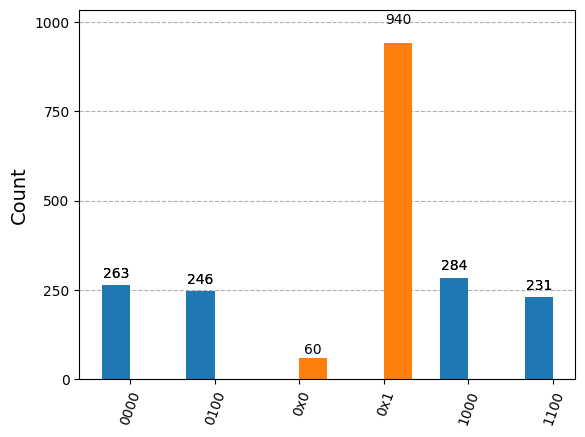

In [60]:
data = job.result().data()
countshw = data['counts']
plot_histogram([counts, countshw])

In [62]:
print(counts)
print(countshw)
bin_dict = {bin(int(key, 16))[2:].zfill(4): value for key, value in countshw.items()}

print(bin_dict)

{'0000': 263, '1100': 231, '1000': 284, '0100': 246}
{'0x1': 940, '0x0': 60}
{'0001': 940, '0000': 60}


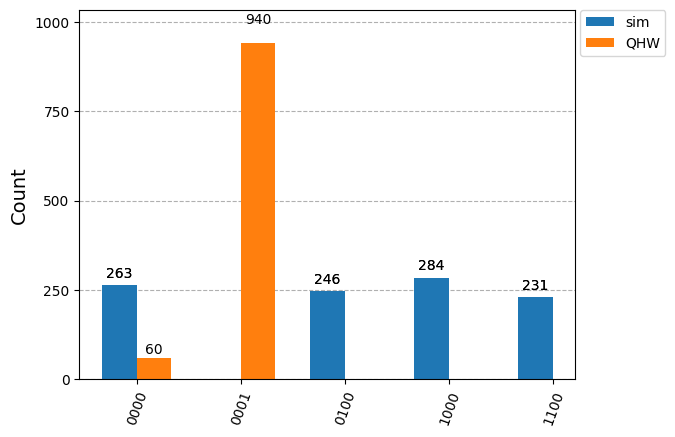

In [64]:
plot_histogram([counts, bin_dict], legend=["sim", "QHW"])

### 4.3 Base 7

ID del resultado de Shor para factorizar 15 con base 4  con 1024 intentos: 'cvynbzzz9es0008e7qy0'